# Generalized Convex Hull construction for the polymorphs of ROY

This notebook analyzes the structures of 264 polymorphs of ROY, from [Beran et Al, Chemical Science (2022)](https://doi.org/10.1039/D1SC06074K), comparing the conventional density-energy convex hull with a Generalized Convex Hull (GCH) analysis (see [Anelli et al., Phys. Rev. Materials (2018)](https://doi.org/10.1103/PhysRevMaterials.2.103804).

In [1]:
import ase.io as aseio
import numpy as np
from sklearn.decomposition import PCA
from skmatter.sample_selection import DirectionalConvexHull
from matplotlib import pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

Loads the structures (that also contain properties in the `info` field)

In [2]:
structures = aseio.read("beran_cs_2022-roy.xyz", ":")

In [3]:
density = np.array([ s.info['density'] for s in structures ])
energy = np.array([ s.info['energy'] for s in structures ])
structype = np.array([ s.info['type'] for s in structures ])
iknown = np.where(structype=="known")[0]
iothers = np.where(structype!="known")[0]

In [4]:
structures[0].info

{'spacegroup': 'P 21/c',
 'unit_cell': 'conventional',
 'energy': 0.0,
 'density': 1.5366,
 'name': '0001_Y',
 'type': 'known'}

## Energy-density hull
The Directional Convex Hull routines can be used to compute a conventional density-energy hull

In [5]:
dch_builder = DirectionalConvexHull(low_dim_idx=[0])
dch_builder.fit(density.reshape(-1,1), energy)

We can get the indices of the selection, and compute the distance from the hull

In [6]:
sel = dch_builder.selected_idx_
dch_dist = dch_builder.score_samples(density.reshape(-1,1), energy)

Structures on the hull are stable with respect to synthesis at constant molar volume. Any other structure would lower the energy by decomposing into a mixture of the two nearest structures along the hull. Given that the lattice energy is an imperfect proxy for the free energy, and that synthesis can be performed in other ways than by fixing the density, structures that are not exactly on the hull might also be stable. One can compute a "hull energy" as an indication of how close these structures are to being stable . 

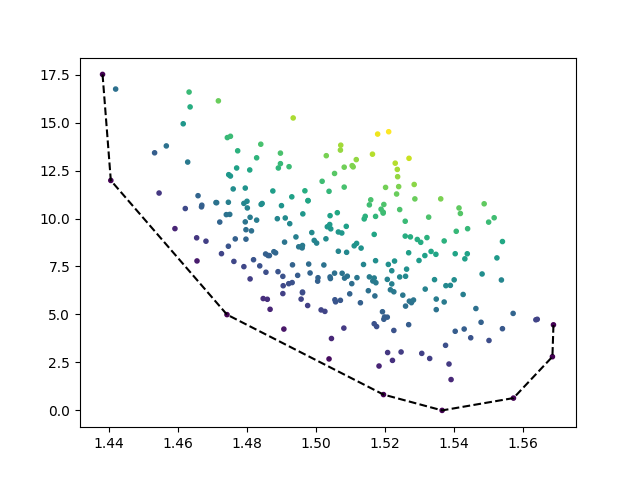

In [7]:
plt.scatter(density,energy,c=dch_dist, marker='.')
ssel = sel[np.argsort(density[sel])]
plt.plot(density[ssel], energy[ssel], 'k--')

In [8]:
print(f"Mean hull energy for 'known' stable structures {dch_dist[iknown].mean()} kca/mol")
print(f"Mean hull energy for 'other' structures {dch_dist[iothers].mean()} kca/mol")

Mean hull energy for 'known' stable structures 1.816657381014075 kca/mol
Mean hull energy for 'other' structures 6.312730486304906 kca/mol


You can also visualize the hull with `chemiscope`

In [9]:
try:
    import chemiscope
    cs = chemiscope.show(structures, 
                dict(energy=energy, density=density, hull_energy = dch_dist,
                     structure_type=structype), 
                   settings={'map': {'x': {'property': 'density'},
  'y': {'property': 'energy'},
  'color': {'property': 'hull_energy'},
  'symbol': 'structure_type',
  'size': {'factor': 35}},
 'structure': [{'unitCell': True,
   'supercell': {'0': 2, '1': 2, '2': 2}}]} )
    display(cs)
except:
    print("Install the `chemiscope` package to generate an interactive visualization of the hull")

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"map": {"x": {"property": "density"}, "y": {"prop…

## Generalized Convex Hull

A GCH is a similar construction, in which generic structural descriptors are used in lieu of composition, density or other thermodynamic constraints. The idea is that configurations that are found close to the GCH are locally stable with respect to structurally-similar configurations. 
In other terms, one can hope to find a thermodynamic constraint (i.e. synthesis conditions) that act differently on these structures in comparison with the others, and may potentially stabilize them. 

A first stept is to computes suitable ML descriptors. Here we use `rascaline`, if available, to evaluate average SOAP features for the structures

In [10]:
try: 
    from rascaline import SoapPowerSpectrum
    from equistore import mean_over_samples
    hypers = {
        "cutoff": 4,
        "max_radial": 6,
        "max_angular": 4,    
        "atomic_gaussian_width": 0.7,
        "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
        "radial_basis": {"Gto": {"accuracy": 1e-6}},
        "center_atom_weight": 1.0 
    }
    calculator = SoapPowerSpectrum(**hypers)
    rho2i = calculator.compute(structures)
    rho2i=rho2i.keys_to_samples(['species_center']).keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])
    rho2i_structure = mean_over_samples(rho2i, sample_names=["center", "species_center"])
    np.savez("roy_features.npz", feats=rho2i_structure.block(0).values)
except:
    raise("Install `rascaline` and `equistore` if you want to compute features.")

... otherwise just loads pre-computed SOAP features.

In [11]:
features = np.load("roy_features.npz")['feats']

Computes PCA projection (one could try any other dimensionality reduction scheme)

In [12]:
pca = PCA(n_components=4)
pca_features = pca.fit_transform(features)

In [13]:
plt.scatter(pca_features[:,0], pca_features[:,1], c=energy)

Builds convex hull on first two PCA features

In [14]:
dch_builder = DirectionalConvexHull(low_dim_idx=[0,1])
dch_builder.fit(pca_features, energy)
sel = dch_builder.selected_idx_
dch_dist = dch_builder.score_samples(pca_features, energy)

3D Plot

Text(0.5, 0, 'energy / kcal/mol')

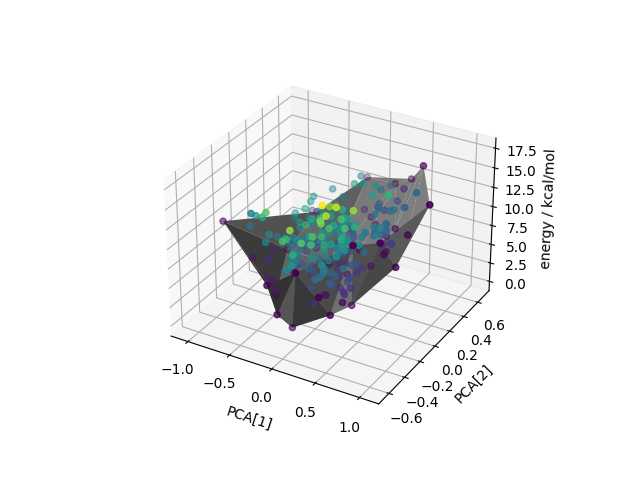

In [15]:
triang = mtri.Triangulation(pca_features[sel,0], pca_features[sel,1])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(triang, energy[sel], color='gray')
ax.scatter(pca_features[:,0], pca_features[:,1], energy, c=dch_dist)
ax.set_xlabel("PCA[1]")
ax.set_ylabel("PCA[2]")
ax.set_zlabel("energy / kcal/mol")

The GCH construction improves the separation between the hull energies of "known" and hypothetical polymorphs (compare with the density-energy values above)

In [16]:
print(f"Mean hull energy for 'known' stable structures {dch_dist[iknown].mean()} kca/mol")
print(f"Mean hull energy for 'other' structures {dch_dist[iothers].mean()} kca/mol")

Mean hull energy for 'known' stable structures 0.853915684690472 kca/mol
Mean hull energy for 'other' structures 5.1987386045400665 kca/mol


In [17]:
# adds PCA features to info fields 
for i, f in enumerate(structures):
    for j in range(len(pca_features[i])):
        f.info['pca_'+str(j+1)] = pca_features[i,j]

Visualize in `chemiscope`, if available. 

In [18]:
try:
    import chemiscope
    structure_properties=chemiscope.extract_properties(structures)
    structure_properties.update({"per_atom_energy":energy, "hull_energy":dch_dist})
    cs = chemiscope.show(frames=structures, 
                     properties=structure_properties, 
                     settings={'map': {'x': {'property': 'pca_1'},
  'y': {'property': 'pca_2'},
  'z': {'property' : 'energy'},
  'symbol': 'type', 'symbol': 'type', 'color' : {'property': 'hull_energy'}, 
  'size': {'factor': 35, 'mode': 'linear', 'property': '', 'reverse': True} ,
},
 'structure': [{'bonds': True,
   'unitCell': True,
   'keepOrientation': True,
   }]})
    display(cs)
except:
    print("Install the `chemiscope` package to generate an interactive visualization of the hull")

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"map": {"x": {"property": "pca_1"}, "y": {"proper…